## Anti-Money Laundher Approach based on Project Aurora
1. **Based on the article here: [file]**
2.  **Key features**
        <br>- Synthetic data
        <br>- Graph database/queries
        <br>- Neural Network for predicting suspicious accounts

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [1]:
import pandas as pd
import numpy as np
import kuzu
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil


In [2]:

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [4]:

# Synthetic data generation
def generate_synthetic_data(num_entities=5000, num_transactions=25000):
    np.random.seed(42)
    entities = pd.DataFrame({
        'entity_id': [f'E{i:04d}' for i in range(num_entities)],
        'profile_type': np.random.choice(['individual_low', 'individual_high', 'business_small', 'business_large'], num_entities, p=[0.4, 0.1, 0.3, 0.2]),
        'agent_id': np.random.randint(1, 100, num_entities),
        'kyc_risk_score': np.random.uniform(0, 0.2, num_entities),
        'dormancy_period': np.random.randint(0, 365, num_entities)
    })
    suspicious = np.random.choice([0, 1], num_entities, p=[0.9, 0.1])
    suspicious_indices = np.where(suspicious)[0]
    entities.loc[suspicious_indices, 'agent_id'] = np.random.choice(entities['agent_id'].iloc[suspicious_indices[:50]], len(suspicious_indices))
    entities.loc[suspicious_indices, 'kyc_risk_score'] = np.random.uniform(0.5, 1.0, len(suspicious_indices))
    entities.loc[suspicious_indices, 'dormancy_period'] = np.random.randint(180, 365, len(suspicious_indices))
    
    transactions = pd.DataFrame({
        'sender_id': np.random.choice(entities['entity_id'], num_transactions),
        'receiver_id': np.random.choice(entities['entity_id'], num_transactions),
        'amount': np.random.exponential(20000, num_transactions).clip(100, 500000),
        'is_cross_border': np.random.choice([True, False], num_transactions, p=[0.15, 0.85]),
        'timestamp': np.random.randint(0, 30, num_transactions),
        'ml_flag': np.zeros(num_transactions, dtype=int),
        'flagged_receiver': np.random.choice([True, False], num_transactions, p=[0.05, 0.95]),
        'high_risk_jurisdiction': np.random.choice([True, False], num_transactions, p=[0.1, 0.9])
    })
    for i, row in entities.iterrows():
        if suspicious[i]:
            mask = transactions['sender_id'] == row['entity_id']
            num_tx = sum(mask)
            transactions.loc[mask, 'ml_flag'] = np.random.choice([0, 1], num_tx, p=[0.1, 0.9])
            transactions.loc[mask, 'amount'] = np.random.uniform(9000, 9999, num_tx) if np.random.random() < 0.5 else np.random.exponential(500, num_tx).clip(5, 100)
            transactions.loc[mask, 'timestamp'] = np.random.randint(0, 3, num_tx)
            transactions.loc[mask, 'is_cross_border'] = np.random.choice([True, False], num_tx, p=[0.98, 0.02])
            transactions.loc[mask, 'high_risk_jurisdiction'] = np.random.choice([True, False], num_tx, p=[0.9, 0.1])
            transactions.loc[mask, 'flagged_receiver'] = np.random.choice([True, False], num_tx, p=[0.7, 0.3])
            if row['profile_type'] in ['individual_low', 'business_small']:
                transactions.loc[mask, 'amount'] = np.random.uniform(50000, 200000, num_tx) if np.random.random() < 0.4 else transactions.loc[mask, 'amount']
    suspicious_transactions = transactions[transactions['ml_flag'] == 1].sample(frac=0.05)
    for idx in suspicious_transactions.index:
        transactions.loc[idx, 'receiver_id'] = transactions.loc[idx, 'sender_id']
    for i, row in entities[entities['dormancy_period'] > 180].iterrows():
        if suspicious[i]:
            mask = transactions['sender_id'] == row['entity_id']
            transactions.loc[mask, 'timestamp'] = np.random.randint(28, 30, sum(mask))
            transactions.loc[mask, 'amount'] = np.random.uniform(10000, 50000, sum(mask))
    entities.to_csv('entities.csv', index=False)
    transactions.to_csv('transactions.csv', index=False)
    print(f"Generated {num_entities} entities and {num_transactions} transactions")
    print(transactions['amount'].describe())
    print(transactions[['is_cross_border', 'ml_flag', 'flagged_receiver', 'high_risk_jurisdiction']].value_counts())
    print(entities[['kyc_risk_score', 'dormancy_period']].describe())

# Regenerate synthetic data
generate_synthetic_data()


Generated 5000 entities and 25000 transactions
count     25000.000000
mean      20945.855392
std       19252.360230
min          44.204117
25%        6532.301992
50%       15644.976375
75%       30262.990100
max      179759.805314
Name: amount, dtype: float64
is_cross_border  ml_flag  flagged_receiver  high_risk_jurisdiction
False            0        False             False                     16263
True             0        False             False                      2955
False            0        False             True                       1820
True             1        True              True                       1455
False            0        True              False                       789
True             1        False             True                        631
                 0        False             True                        411
                          True              True                        179
                 1        True              False                

In [6]:

# Clear and recreate Kuzu database
db_path = 'kuzu_db'
if os.path.exists(db_path):
    shutil.rmtree(db_path)
print("Creating new Kuzu database")
db = kuzu.Database(db_path)
conn = kuzu.Connection(db)
conn.execute("CREATE NODE TABLE Entity(entity_id STRING, profile_type STRING, agent_id INT, kyc_risk_score DOUBLE, dormancy_period INT, PRIMARY KEY(entity_id))")
conn.execute("CREATE REL TABLE Transaction(FROM Entity TO Entity, amount DOUBLE, is_cross_border BOOLEAN, timestamp INT, ml_flag INT, flagged_receiver BOOLEAN, high_risk_jurisdiction BOOLEAN)")
conn.execute("COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
conn.execute("COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")

# Verify database
result = conn.execute("MATCH (e:Entity) RETURN COUNT(e)")
num_entities = result.get_next()[0]
result = conn.execute("MATCH ()-[t:Transaction]->() RETURN COUNT(t)")
num_transactions = result.get_next()[0]
print(f"Number of entities: {num_entities}")
print(f"Number of transactions: {num_transactions}")
if num_entities == 0 or num_transactions == 0:
    raise ValueError("Database is empty.")


Creating new Kuzu database
Number of entities: 5000
Number of transactions: 25000


In [8]:


# Query 1: Degree
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    degree_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Small transaction count
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Query 4: Clustering coefficient
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t1:Transaction]->(m:Entity)-[t2:Transaction]->(n:Entity)
        WHERE n.entity_id = e.entity_id
        RETURN e.entity_id, COUNT(DISTINCT m) AS clustering_coeff
    """)
    cluster_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'clustering_coeff'])
    cluster_df['clustering_coeff'] = pd.to_numeric(cluster_df['clustering_coeff'], errors='coerce')
except Exception as e:
    print(f"Error executing clustering coefficient query: {e}")
    raise

# Query 5: Transaction frequency variance
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS tx_count
    """)
    tx_count_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'tx_count'])
    tx_count_df['tx_count'] = pd.to_numeric(tx_count_df['tx_count'], errors='coerce')
    mean_tx_count = tx_count_df['tx_count'].mean()
    tx_count_df['tx_freq_variance'] = (tx_count_df['tx_count'] - mean_tx_count) ** 2
    tx_freq_df = tx_count_df.groupby('entity_id').agg({'tx_freq_variance': 'mean'}).reset_index()
    tx_freq_df['tx_freq_variance'] = np.sqrt(tx_freq_df['tx_freq_variance']).fillna(0)
except Exception as e:
    print(f"Error computing tx frequency variance: {e}")
    raise

# Query 6: Amount variance and skewness
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, t.amount AS amount
    """)
    amount_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                            columns=['entity_id', 'amount'])
    amount_df['amount'] = pd.to_numeric(amount_df['amount'], errors='coerce')
    var_skew_df = amount_df.groupby('entity_id').agg({
        'amount': [
            ('avg_amount', 'mean'),
            ('amount_variance', lambda x: np.var(x, ddof=1) if len(x) > 1 else 0),
            ('amount_skewness', lambda x: ((x - x.mean()) ** 3).mean() / (x.std(ddof=1) ** 3 + 1e-7) if len(x) > 1 else 0)
        ]
    }).droplevel(0, axis=1).reset_index()
    var_skew_df[['amount_variance', 'amount_skewness']] = var_skew_df[['amount_variance', 'amount_skewness']].fillna(0)
except Exception as e:
    print(f"Error computing amount variance/skewness: {e}")
    raise

# Query 7: Transaction velocity and burstiness
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, t.timestamp AS timestamp
    """)
    time_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                          columns=['entity_id', 'timestamp'])
    time_df['timestamp'] = pd.to_numeric(time_df['timestamp'], errors='coerce')
    time_agg_df = time_df.groupby('entity_id').agg({
        'timestamp': [
            ('tx_velocity', lambda x: len(x) / (x.max() - x.min() + 1e-7)),
            ('burstiness', lambda x: np.var(x, ddof=1) if len(x) > 1 else 0)
        ]
    }).droplevel(0, axis=1).reset_index()
    time_agg_df[['tx_velocity', 'burstiness']] = time_agg_df[['tx_velocity', 'burstiness']].fillna(0)
except Exception as e:
    print(f"Error computing temporal features: {e}")
    raise

# Query 8: Additional features
try:
    result = conn.execute("""
        MATCH (e:Entity)
        OPTIONAL MATCH (e)-[t:Transaction]->()
        OPTIONAL MATCH ()-[t_in:Transaction]->(e)
        RETURN e.entity_id, 
               e.kyc_risk_score AS kyc_risk_score,
               e.dormancy_period AS dormancy_period,
               COALESCE(SUM(CASE WHEN t.is_cross_border THEN t.amount ELSE 0 END), 0) AS cross_border_amount,
               COALESCE(SUM(CASE WHEN t.flagged_receiver THEN 1 ELSE 0 END), 0) AS flagged_tx_count,
               COALESCE(SUM(CASE WHEN t.high_risk_jurisdiction THEN 1 ELSE 0 END), 0) AS high_risk_tx_count,
               COALESCE(COUNT(t_in), 0) AS in_degree,
               COALESCE(COUNT(t), 0) AS tx_frequency
    """)
    features_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'kyc_risk_score', 'dormancy_period', 'cross_border_amount', 'flagged_tx_count', 'high_risk_tx_count', 'in_degree', 'tx_frequency'])
    numeric_cols = ['kyc_risk_score', 'dormancy_period', 'cross_border_amount', 'flagged_tx_count', 'high_risk_tx_count', 'in_degree', 'tx_frequency']
    features_df[numeric_cols] = features_df[numeric_cols].apply(pd.to_numeric, errors='coerce', downcast='float')
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Query 9: Round-tripping
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->(e2:Entity)
        WHERE e.entity_id = e2.entity_id
        RETURN e.entity_id, COUNT(t) AS round_trip_count
    """)
    round_trip_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                                columns=['entity_id', 'round_trip_count'])
    round_trip_df['round_trip_count'] = pd.to_numeric(round_trip_df['round_trip_count'], errors='coerce')
except Exception as e:
    print(f"Error computing round-trip count: {e}")
    round_trip_df = pd.DataFrame({'entity_id': entities['entity_id'], 'round_trip_count': 0})

# Merge features
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(var_skew_df, on='entity_id', how='left').merge(cluster_df, on='entity_id', how='left').merge(tx_freq_df, on='entity_id', how='left').merge(time_agg_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left').merge(round_trip_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'amount_variance': 0, 'amount_skewness': 0, 'clustering_coeff': 0, 'tx_freq_variance': 0, 'tx_velocity': 0, 'burstiness': 0, 'kyc_risk_score': 0, 'dormancy_period': 0, 'cross_border_amount': 0, 'flagged_tx_count': 0, 'high_risk_tx_count': 0, 'in_degree': 0, 'tx_frequency': 0, 'round_trip_count': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("NaN counts:")
print(data_df.isna().sum())
print("Data types:")
print(data_df.dtypes)

# Compute ml_flag and labels
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, AVG(t.ml_flag) AS ml_flag_score
    """)
    ml_flag_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'ml_flag_score'])
    ml_flag_df['ml_flag_score'] = pd.to_numeric(ml_flag_df['ml_flag_score'], errors='coerce').fillna(0)
    data_df = data_df.merge(ml_flag_df, on='entity_id', how='left').fillna({'ml_flag_score': 0})
    data_df['is_anomaly'] = (data_df['ml_flag_score'] > 0.03).astype(int)
except Exception as e:
    print(f"Error computing ml_flag_score: {e}")
    data_df['is_anomaly'] = np.zeros(len(data_df), dtype=int)

# Feature selection
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'amount_variance', 'amount_skewness', 'clustering_coeff', 'tx_freq_variance', 'tx_velocity', 'burstiness', 'kyc_risk_score', 'dormancy_period', 'cross_border_amount', 'flagged_tx_count', 'high_risk_tx_count', 'round_trip_count']
X = data_df[feature_columns].values

# Verify X
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))


Merged data_df:
  entity_id  degree  small_tx_count    avg_amount  amount_variance  \
0     E0639       3             1.0  29111.820175     6.639663e+08   
1     E2645       6             0.0  21542.365052     5.198390e+08   
2     E4813       3             0.0  13105.575002     1.478256e+08   
3     E2153      10             0.0  23774.379145     3.092388e+08   
4     E2985       6             0.0  20064.267352     1.661741e+08   

   amount_skewness  clustering_coeff  tx_freq_variance  tx_velocity  \
0        -0.301363               0.0          2.044391     0.150000   
1         0.696019               0.0          0.955609     0.214286   
2         0.313423               0.0          2.044391     0.375000   
3         0.014287               0.0          4.955609     0.384615   
4         0.447403               0.0          0.955609     0.230769   

   burstiness  kyc_risk_score  dormancy_period  cross_border_amount  \
0  103.000000        0.088153             48.0             0.0000

In [9]:
import pandas as pd
import numpy as np
import kuzu
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Synthetic data generation (as above)
# [Insert the generate_synthetic_data function from above]

# Regenerate synthetic data
generate_synthetic_data()




Generated 5000 entities and 25000 transactions
count     25000.000000
mean      20945.855392
std       19252.360230
min          44.204117
25%        6532.301992
50%       15644.976375
75%       30262.990100
max      179759.805314
Name: amount, dtype: float64
is_cross_border  ml_flag  flagged_receiver  high_risk_jurisdiction
False            0        False             False                     16263
True             0        False             False                      2955
False            0        False             True                       1820
True             1        True              True                       1455
False            0        True              False                       789
True             1        False             True                        631
                 0        False             True                        411
                          True              True                        179
                 1        True              False                

Epoch 0, Loss: 0.6496
Epoch 10, Loss: 0.6240
Epoch 20, Loss: 0.5949
Epoch 30, Loss: 0.5210
Epoch 40, Loss: 0.4269
Epoch 50, Loss: 0.3789
Epoch 60, Loss: 0.3291
Epoch 70, Loss: 0.2971
Epoch 80, Loss: 0.2531
Epoch 90, Loss: 0.2243
Overall Precision: 0.9234
Overall Recall: 0.8740
Overall F1 Score: 0.8980

Fold 1
Fold 1 Precision: 0.9437, Recall: 0.8171, F1: 0.8758
Fold 1 Mean Anomaly Score: 2.3775
Validation Anomaly Scores (first 10): [1.5871535e-01 5.6019324e-01 4.5123577e-01 3.3258241e-02 6.1989939e-01
 4.8950320e-01 4.8959229e+01 8.7714404e-01 5.8926058e-01 2.8029120e-01]

Fold 2
Fold 2 Precision: 0.9296, Recall: 0.8462, F1: 0.8859
Fold 2 Mean Anomaly Score: 2.7567
Validation Anomaly Scores (first 10): [ 0.5636793   0.18148221  0.38118875  0.889945    0.32965574  7.7934422
 33.194817    0.62186396 59.529663    5.8977504 ]

Fold 3
Fold 3 Precision: 0.8028, Recall: 1.0000, F1: 0.8906
Fold 3 Mean Anomaly Score: 1.7900
Validation Anomaly Scores (first 10): [2.062229   0.669335   0.08409163

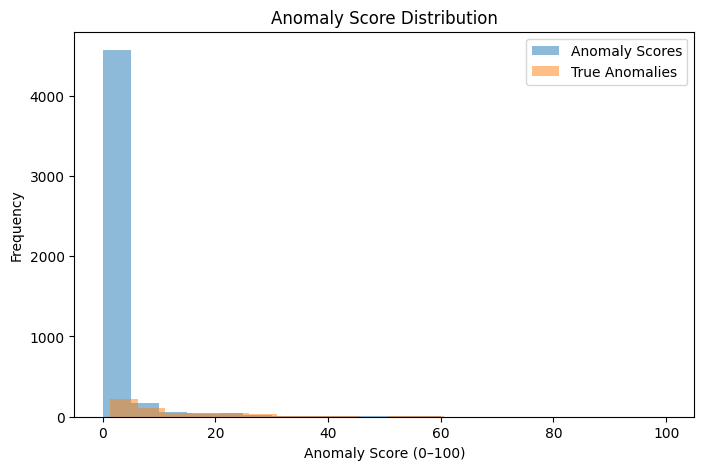

Feature correlations with anomaly score:
degree                 0.097616
small_tx_count        -0.093571
avg_amount             0.228940
amount_variance       -0.084283
amount_skewness       -0.160475
clustering_coeff       0.705346
tx_freq_variance       0.034911
tx_velocity            0.278279
burstiness            -0.286250
kyc_risk_score         0.628687
dormancy_period        0.182326
cross_border_amount    0.769487
flagged_tx_count       0.779791
high_risk_tx_count     0.771546
round_trip_count       0.783648
Name: anomaly_score, dtype: float64


In [10]:
# Autoencoder training on normal data
normal_idx = data_df['is_anomaly'] == 0
X_normal = X[normal_idx]
X_normal_tensor = torch.FloatTensor(X_normal)
input_dim = X.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
for epoch in range(100):
    autoencoder.train()
    optimizer.zero_grad()
    outputs = autoencoder(X_normal_tensor)
    loss = criterion(outputs, X_normal_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Compute reconstruction errors
autoencoder.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X)
    reconstructed = autoencoder(X_tensor)
    reconstruction_errors = torch.mean((reconstructed - X_tensor) ** 2, dim=1).numpy()
anomaly_scores = 100 * (reconstruction_errors - reconstruction_errors.min()) / (reconstruction_errors.max() - reconstruction_errors.min() + 1e-7)
data_df['anomaly_score'] = anomaly_scores
threshold = np.percentile(anomaly_scores, 90)  # Top 10% as anomalies
data_df['predicted_anomaly'] = (anomaly_scores > threshold).astype(int)

# Evaluate
if 'is_anomaly' in data_df.columns:
    precision = precision_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    recall = recall_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    f1 = f1_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

# K-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
fold = 1
precisions = []
recalls = []
f1_scores = []
mean_anomaly_scores = []

for train_idx, val_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_val = data_df['is_anomaly'].iloc[val_idx]
    train_normal_idx = data_df.iloc[train_idx]['is_anomaly'] == 0
    X_train_normal = X_train[train_normal_idx]
    X_train_normal_tensor = torch.FloatTensor(X_train_normal)
    X_val_tensor = torch.FloatTensor(X_val)
    
    autoencoder = Autoencoder(input_dim)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    for epoch in range(100):
        autoencoder.train()
        optimizer.zero_grad()
        outputs = autoencoder(X_train_normal_tensor)
        loss = criterion(outputs, X_train_normal_tensor)
        loss.backward()
        optimizer.step()
    
    autoencoder.eval()
    with torch.no_grad():
        reconstructed_val = autoencoder(X_val_tensor)
        val_errors = torch.mean((reconstructed_val - X_val_tensor) ** 2, dim=1).numpy()
    val_scores = 100 * (val_errors - val_errors.min()) / (val_errors.max() - val_errors.min() + 1e-7)
    val_predictions = (val_scores > np.percentile(val_scores, 90)).astype(int)
    
    precision = precision_score(y_val, val_predictions, zero_division=0)
    recall = recall_score(y_val, val_predictions, zero_division=0)
    f1 = f1_score(y_val, val_predictions, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    mean_anomaly_scores.append(np.mean(val_scores))
    
    print(f"Fold {fold} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Fold {fold} Mean Anomaly Score: {np.mean(val_scores):.4f}")
    print(f"Validation Anomaly Scores (first 10): {val_scores[:10]}")
    fold += 1

# Average metrics
print(f"\nAverage Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Mean Anomaly Score: {np.mean(mean_anomaly_scores):.4f}")

# Plot anomaly score distribution
plt.figure(figsize=(8, 5))
plt.hist(data_df['anomaly_score'], bins=20, alpha=0.5, label='Anomaly Scores')
plt.hist(data_df[data_df['is_anomaly'] == 1]['anomaly_score'], bins=20, alpha=0.5, label='True Anomalies')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score (0–100)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Feature correlations
print("Feature correlations with anomaly score:")
correlations = data_df[feature_columns + ['anomaly_score']].corr()['anomaly_score'].drop('anomaly_score')
print(correlations)

# Save results
data_df.to_csv('anomaly_results.csv', index=False)

**Changed below**:
Precision and other metrics seem way too high, exceding Project Aurora's metrics. Need to make changes to ensure truthful and accurate synthetic data